# Adiabatic State prep for QSCI

This is a usecase for adiabatic state-preparation. The idea is to run TE QSCI, but using adiabatic time-evolution.

## Adiabatic theorem

Let $H(t)$ be a Hamiltonian that changes smoothly as a function of $t$ and let $H(t)\ket{\psi_0(t)} = \lambda_0(t)\ket{\psi_0(t)}$. Here $\lambda_0(t)$ is the ground state energy and $\ket{\psi_0(t)}$ the corresponding ground state. We consider the situation where on the entire interval $t \in [0, t_\textup{end}]$

- $H(t)$ is gapped
- $t_\textup{end} \gg \braket{\partial H (t)/ \partial t} / \Delta (t)^2 $, where $\Delta(t)$ is the excitation gap.

Now we define the state
$$\ket{\phi(t)} = \ket{\psi_0(0)}e^{-i\int_0^t H(t') dt'}$$
To a good approximation, under the above conditions $\ket{\phi(t)} \approx \ket{\psi_0(t)}$.

## Use-case

It seems reasonable that the overlap with the ground state should remain large, even if I don't know the exact ground state. So as a user, I would like to use this with QSCI.

We consider the transverse field Ising model

$$H = -J\sum_{i=1}^{N} X_i X_{i+1} - h\sum_{i=1}^N Z_i$$

In the thermodynamic limit, this model shows a quantum phase transition at $h = J$. So let's see how good the above approach remains as we approach this point. As a user I would like to do something like

### Example 1

I start in the state $\ket{0\ldots 0}$ corresponding to the magnetically ordered state that is the ground state at $h\rightarrow \infty$. I am interested in the near-critical behaviour and I want to see how well adiabatic state preparation works, so I want to do something like

In [ ]:
class AdiabaticTimeEvolutionCircuitFactory:
    pass

H_0 = ...
H_1 = ...

t_end = 1.0
H_t = lambda t: H_0 + (t - t_end) * H_1

cf = AdiabaticTimeEvolutionCircuitFactory(H_t)
circuit = cf(t_end)  # calling it only using the evolution time in this case

### Example 2
With the above code, I am only supplying the Hamiltonian and $t_\textup{end}$, but I want to have more control over the way that the time-evolution is carried out. There are two things I want to control.

1. The discretization of $H(t)$ in terms of time-steps, by supplying the number of discretizations of the Hamiltonian
2. The way circuits are generated at each time-step by supplying a `TimeEvolutionCircuitFactory`

In [ ]:
from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterTimeEvolutionCircuitFactory
from quri_algo.circuit.time_evolution.exact_unitary import ExactUnitaryTimeEvolutionCircuitFactory

class AdiabaticTimeEvolutionCircuitFactory:
    pass

H_0 = ...
H_1 = ...

t_end = 1.0
H_t = lambda t: H_0 + (t - t_end) * H_1

n_discretization = 20

# Using Trotterization
cf = AdiabaticTimeEvolutionCircuitFactory(H_t, TrotterTimeEvolutionCircuitFactory)
circuit = cf(t_end, n_discretization)  # Performs the Trotterization with a different U(t) at each time-step. n_discretization is equal to n_trotter (there is no reason not to discretize at each trotter step)

# Using exact unitary
cf = AdiabaticTimeEvolutionCircuitFactory(H_t, ExactUnitaryTimeEvolutionCircuitFactory)
circuit = cf(t_end, n_discretization)  # Performs the Exact time-evolution with a different U(t) at each time-step

### Example 3

I know that as I approach the critical point of the TFIM, the adiabatic condition will be weakened since the gap shrinks. That makes me think that it is ok to modify the way that I interpolate between $H(0)$ and $H(t_\textup{end}$, but I don't want to write a new function every time. Maybe I can just apply an interpolating function instead and let the circuit factory handle the rest.

I would like to try the following interpolations to slow down the change in $h$

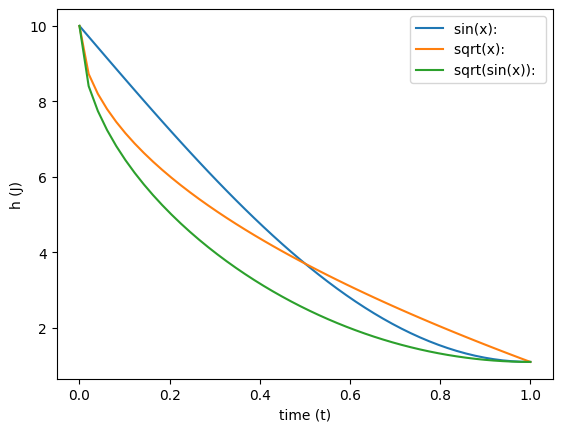

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, sin, pi

interp_func_sqrt = lambda x: sqrt(x)
interp_func_sin = lambda x: sin(x*pi/2)
interp_func_sqrtsin = lambda x: sqrt(sin(x*pi/2))

h_start = 10.0
h_end = 1.1

time = np.linspace(0,1.0,50)

interpolating_functions = {
    "sin(x): ": interp_func_sin,
    "sqrt(x): ": interp_func_sqrt,
    "sqrt(sin(x)): ": interp_func_sqrtsin}

plt.xlabel('time (t)')
plt.ylabel('h (J)')
for s, f in interpolating_functions.items():
    plt.plot(time, [h_start + (h_end - h_start)*f(t) for t in time], label=s)
plt.legend()

For this I would like to use it as

In [ ]:
from numpy import sqrt, sin, pi
from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterTimeEvolutionCircuitFactory

class AdiabaticTimeEvolutionCircuitFactory:
    pass

H_0 = ...
H_1 = ...

t_end = 1.0
H_t = lambda t: H_0 + (t - t_end) * H_1

n_discretization = 20

interp_func_sqrt = lambda x: sqrt(x)
interp_func_sin = lambda x: sin(x*pi/2)
interp_func_sqrtsin = lambda x: sqrt(sin(x*pi/2))


# Using Trotterization
cf = AdiabaticTimeEvolutionCircuitFactory(H_t, TrotterTimeEvolutionCircuitFactory)
circuit = cf(t_end, n_discretization, interp_func_sin)

### Example 4

I would like to now try running it with QSCI. I know that I have to prepare the Hamiltonian before-hand and then prepare the number of discretizations and the interpolating function. Then that will give me a circuit in return like the example above. However, I would also like to obtain the circuit generated at each time-step. The reason is that I would like to evaluate the TE QSCI at each time-step, not just at the end. So for that I would need something like

In [ ]:
from numpy import sqrt, sin, pi, linspace
from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterTimeEvolutionCircuitFactory

class AdiabaticTimeEvolutionCircuitFactory:
    pass

H_0 = ...
H_1 = ...

t_end = 1.0
H_t = lambda t: H_0 + (t - t_end) * H_1

n_discretization = 20

interp_func_sqrt = lambda x: sqrt(x)
interp_func_sin = lambda x: sin(x*pi/2)
interp_func_sqrtsin = lambda x: sqrt(sin(x*pi/2))


# Using Trotterization
cf = AdiabaticTimeEvolutionCircuitFactory(H_t, TrotterTimeEvolutionCircuitFactory)
circuits = []
for t in linspace(t_end/n_discretization, t_end, n_discretization):
    circuit = cf(t_end, n_discretization, interp_func_sin, until=t)

However, this could be very slow if we are not careful because there will be several calls to the same functions. Especially if we use something like exact time-evolution, that could be very expensive.

We should make sure that generated circuits can be reused.

## Interface

We can achieve something like the above examples with the interface below

In [2]:
from typing import Callable, Sequence, Optional, Any

from quri_parts.circuit import ImmutableQuantumCircuit
from quri_algo.problem.operators.hamiltonian import QubitHamiltonian
from quri_algo.circuit.time_evolution.interface import TimeEvolutionCircuitFactory


HamiltonianMapping = Callable[[float],QubitHamiltonian]


def get_interpolated_hamiltonian_mapping(time_seq: Sequence[float], hamiltonians: Sequence[QubitHamiltonian]) -> HamiltonianMapping:
    """Take a sequence of times and Hamiltonians and return an object that interpolates linearly from each Hamiltonian in the sequence to the next
    
    This is just a helper function, in reality I think that in many use-cases it is not needed."""
    ...


class AdiabaticTimeEvolutionCircuitFactory(TimeEvolutionCircuitFactory):
    def __init__(self, h_t: HamiltonianMapping, time_evo: TimeEvolutionCircuitFactory):
        self.h = h_t
        self.time_evo = time_evo

    def __call__(self, evolution_time: float, discretization: int, interp_function: Optional[Callable[[float],float]] = lambda x: x, *args: Any, **kwargs: Any) -> ImmutableQuantumCircuit:
        """Generate ImmutableQuantumCircuit
        
        Arguments:
            evolution_time: The total evolution time
            discretization: The number of times the TE operator is discretized
            interp_function: Function that must map [0, 1] -> [0, 1]. It can be used to modify the type of interpolation carried out, between the initial and final time, e.g. linear, quadratic, etc.
        """
        ...


## Running QSCI with adiabatic state preparation

Now let's try to run QSCI using the above ideas. First we define some helper function

In [2]:
from typing import Sequence
from quri_parts.core.operator import Operator
from quri_algo.problem.operators.hamiltonian import QubitHamiltonian
from quri_parts.core.state import CircuitQuantumState, GeneralCircuitQuantumState
from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterTimeEvolutionCircuitFactory
from quri_algo.circuit.time_evolution.exact_unitary import ExactUnitaryTimeEvolutionCircuitFactory

def get_time_evolved_state(hams: Sequence[Operator], dt: float, state: CircuitQuantumState) -> CircuitQuantumState:
    for h in hams:
        qubit_h = QubitHamiltonian(state.qubit_count, h)
        time_evo = ExactUnitaryTimeEvolutionCircuitFactory(qubit_h)
        circuit = time_evo(dt)
        state = state.with_gates_applied(circuit)

    return state

Then the Hamiltonian

In [3]:
from quri_parts.core.operator import Operator, pauli_label

def get_TFIM(qubit_count: int, h: float) -> Operator:
    hamiltonian = Operator()

    # Add Ising interaction terms (-J Σ X_i X_{i+1}) (Assuming periodic boundary conditions)
    for i in range(qubit_count):
        pauli_index = pauli_label('X'+str(i)+' X'+str((i+1)%qubit_count))
        hamiltonian.add_term(pauli_index, -1.0)

    # Add transverse field terms (-h Σ Z_i)
    for i in range(qubit_count):
        pauli_index = pauli_label('Z'+str(i))
        hamiltonian.add_term(pauli_index, -h)

    return hamiltonian

In [4]:
from scipy.sparse.linalg import eigsh
from quri_parts.core.state.comp_basis import ComputationalBasisState
from quri_parts.qulacs.sampler import create_qulacs_general_vector_sampler
from quri_parts.core.operator.sparse import get_sparse_matrix

h = get_TFIM(4, 100.0)
print(h)
eigval, eigvec = eigsh(get_sparse_matrix(h),k=2,which='SA')
eigval[0]
eigval[1]

-1.0*X0 X1 + -1.0*X1 X2 + -1.0*X2 X3 + -1.0*X0 X3 + -100.0*Z0 + -100.0*Z1 + -100.0*Z2 + -100.0*Z3


-202.0099997500127

Now we just need to define map the Hamiltonian for each value of $h$ to a time-step and then we can run it.

In [5]:
from scipy.sparse.linalg import eigsh
from quri_parts.core.state.comp_basis import ComputationalBasisState
from quri_parts.qulacs.sampler import create_qulacs_general_vector_sampler
from quri_parts.core.operator.sparse import get_sparse_matrix

from numpy import linspace, sqrt, sin, pi
from quri_parts_qsci import qsci

N_TIME_STEPS = 10
QUBIT_COUNT = 6
N_SHOTS = 10000
T_END = 1.0
R = None
h_0 = 10.0
h_1 = 1.1

a = linspace(0.0,1.0,N_TIME_STEPS)

interp_linear = lambda x: x
interp_func_sqrt = lambda x: sqrt(x)
interp_func_sin = lambda x: sin(x*pi/2)
interp_func_sqrtsin = lambda x: sqrt(sin(x*pi/2))
interp_func_one = lambda _: 1.0

interp_funcs = (interp_linear, interp_func_sqrt, interp_func_sin, interp_func_sqrtsin, interp_func_one)

state = ComputationalBasisState(QUBIT_COUNT, bits = 0)
sampler = create_qulacs_general_vector_sampler()

ham_end = get_TFIM(QUBIT_COUNT, h_1)

eigval, eigvec = eigsh(get_sparse_matrix(ham_end),k=1,which='SA')
gs_energy = eigval[0]
print("gs energy = ", gs_energy)

t0_qsci_result = qsci(ham_end,[state],sampler,N_SHOTS,num_states_pick_out=R)
te_qsci_result = {f: [(t0_qsci_result[0][0], 0.0)] for f in interp_funcs}

for f in interp_funcs:
    for i in range(len(a)):
        hams = [get_TFIM(QUBIT_COUNT, h_0 + (h_1-h_0)*f(x)) for x in a[:(i+1)]]
        evolved_state = get_time_evolved_state(hams, T_END/N_TIME_STEPS, state)
        qsci_res = qsci(ham_end,[evolved_state],sampler,N_SHOTS,num_states_pick_out=R)
        te_qsci_result[f].append(
                (qsci_res[0][0], (i+1)*T_END/N_TIME_STEPS)
            )

gs energy =  -8.134505109904513


We calculate the error relative to the Hamiltonian 1-norm

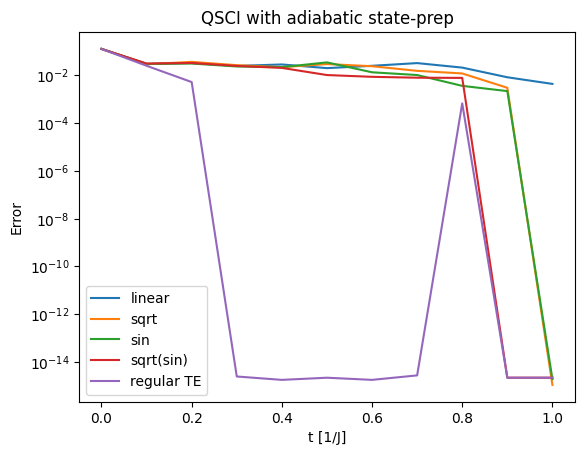

In [6]:
import matplotlib.pyplot as plt

from numpy import abs

one_norm = sum([abs(v) for v in ham_end.values()])

f_strs = {interp_linear: "linear", interp_func_sin: "sin", interp_func_sqrt: "sqrt", interp_func_sqrtsin: "sqrt(sin)", interp_func_one: "regular TE"}

fig, ax1 = plt.subplots()

for f in interp_funcs:
    t = [x[1] for x in te_qsci_result[f]]
    err = [abs(x[0] - gs_energy)/one_norm for x in te_qsci_result[f]]

    ax1.semilogy(t,err,label=f_strs[f])

ax1.set_title("QSCI with adiabatic state-prep")
ax1.set_xlabel("t [1/J]")
ax1.set_ylabel("Error")
ax1.legend()

In [7]:
from scipy.sparse.linalg import eigsh
from quri_parts.core.state.comp_basis import ComputationalBasisState
from quri_parts.qulacs.sampler import create_qulacs_general_vector_sampler
from quri_parts.core.operator.sparse import get_sparse_matrix

from numpy import linspace, sqrt, sin, pi
from quri_parts_qsci import qsci

N_TIME_STEPS = 15
QUBIT_COUNT = 6
N_SHOTS = 10000
T_END = 60.0
R = None
h_0 = 10.0
h_1 = 5.0

a = linspace(0.0, 1.0, N_TIME_STEPS)

interp_linear = lambda x: x
interp_func_sqrt = lambda x: sqrt(x)
interp_func_sin = lambda x: sin(x*pi/2)
interp_func_sqrtsin = lambda x: sqrt(sin(x*pi/2))
interp_func_one = lambda _: 1.0

interp_funcs = (interp_linear, interp_func_sqrt, interp_func_sin, interp_func_sqrtsin, interp_func_one)

state = ComputationalBasisState(QUBIT_COUNT, bits = 0)
sampler = create_qulacs_general_vector_sampler()

ham_end = get_TFIM(QUBIT_COUNT, h_1)
ham_init = get_TFIM(QUBIT_COUNT, h_0)

eigval_end, _ = eigsh(get_sparse_matrix(ham_end),k=2,which='SA')
gs_energy = eigval_end[0]
print("gs energy = ", gs_energy)
eigval, _ = eigsh(get_sparse_matrix(ham_init),k=2,which='SA')

t0_qsci_result = qsci(ham_end,[state],sampler,N_SHOTS,num_states_pick_out=R)
te_qsci_result = {f: [(t0_qsci_result[0][0], 0.0, eigval[1] - eigval[0])] for f in interp_funcs}

for f in interp_funcs:
    for i in range(len(a)):
        hams = [get_TFIM(QUBIT_COUNT, h_0 + (h_1-h_0)*f(x)) for x in a[:(i+1)]]
        evolved_state = get_time_evolved_state(hams, T_END/N_TIME_STEPS, state)
        eigval, _ = eigsh(get_sparse_matrix(hams[-1]),k=2,which='SA')
        qsci_res = qsci(ham_end,[evolved_state],sampler,N_SHOTS,num_states_pick_out=R)
        te_qsci_result[f].append(
                (qsci_res[0][0], (i+1)*T_END/N_TIME_STEPS, eigval[1] - eigval[0])
            )

gs energy =  -30.30083512011997


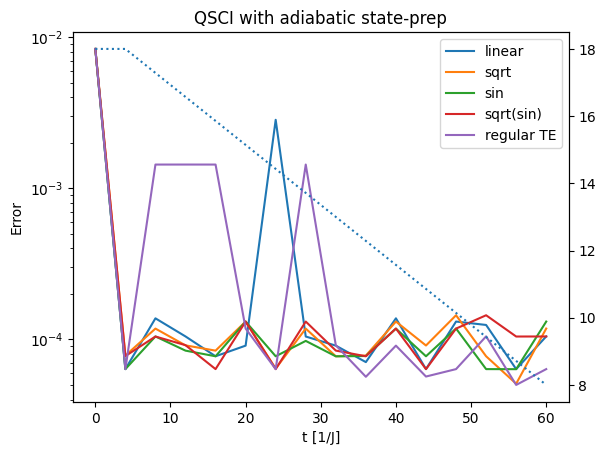

In [8]:
import matplotlib.pyplot as plt

from numpy import abs

one_norm = sum([abs(v) for v in ham_end.values()])

f_strs = {interp_linear: "linear", interp_func_sin: "sin", interp_func_sqrt: "sqrt", interp_func_sqrtsin: "sqrt(sin)", interp_func_one: "regular TE"}

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

for f in interp_funcs:
    t = [x[1] for x in te_qsci_result[f]]
    err = [abs(x[0] - gs_energy)/one_norm for x in te_qsci_result[f]]

    ax1.semilogy(t,err,label=f_strs[f])
exc_gap = [x[2] for x in te_qsci_result[interp_linear]]
ax2.plot(t, exc_gap, linestyle=":", label="Excitation gap")

ax1.set_title("QSCI with adiabatic state-prep")
ax1.set_xlabel("t [1/J]")
ax1.set_ylabel("Error")
ax1.legend()

In [16]:
import numpy as np
from scipy.sparse.linalg import eigsh
from quri_parts.core.state.comp_basis import ComputationalBasisState
from quri_parts.core.operator.sparse import get_sparse_matrix
from quri_parts.core.state import GeneralCircuitQuantumState
from quri_parts.qulacs.sampler import create_qulacs_general_vector_sampler
from quri_parts.qulacs.simulator import evaluate_state_to_vector

def get_exact_ground_state(hamiltonian):
    """Compute exact ground state of a Hamiltonian"""
    sparse_h = get_sparse_matrix(hamiltonian)
    eigval, eigvec = eigsh(sparse_h, k=1, which='SA')
    ground_energy = eigval[0]
    ground_state_vector = eigvec[:, 0]
    return ground_energy, ground_state_vector

def get_qsci_ground_state(hamiltonian, trial_state, shot_count, num_states_pick_out = None):
    trial_state.qubit_count

    eigval, _ = qsci(hamiltonian,[trial_state],create_qulacs_general_vector_sampler(),shot_count,num_states_pick_out=num_states_pick_out)
    
    ground_energy = eigval[0]
    # ground_state_vector = evaluate_state_to_vector(eigvec[0]).vector
    return ground_energy  #, ground_state_vector


def compute_state_overlap(state1_vector, state2_vector):
    """Compute overlap between two quantum state vectors"""
    return abs(np.vdot(state1_vector, state2_vector))**2

def get_state_vector(quantum_state):
    """Convert quantum state to state vector"""
    
    # Use the qulacs backend to get the state vector directly
    return evaluate_state_to_vector(quantum_state).vector

def test_adiabatic_fidelity(qubit_count=4, h_start=10.0, h_end=1.1, n_steps=20, 
                           evolution_time=10.0, shot_count=10000, interp_func=None, r=None):
    """
    Test how well adiabatic evolution follows the exact ground state
    
    Returns:
        times: Array of time points
        overlaps: Ground state overlaps at each time
        energy_errors: Energy errors at each time
        exact_energies: Exact ground state energies
        adiabatic_energies: Adiabatic state energies
    """
    if interp_func is None:
        interp_func = lambda x: x  # Linear interpolation
    
    # Time points
    times = np.linspace(0, evolution_time, n_steps + 1)
    dt = evolution_time / n_steps
    
    # Initialize arrays to store results
    overlaps = []
    energy_errors = []
    exact_energies = []
    adiabatic_energies = []
    qsci_energy_errors = []
    qsci_adiabatic_energies = []
    
    # Initial state (computational basis |0...0>)
    adiabatic_state = ComputationalBasisState(qubit_count, bits=0)
    
    for i, t in enumerate(times):
        # Current interpolation parameter
        assert evolution_time > 0
        s = interp_func(t / evolution_time)
        h_current = h_start + (h_end - h_start) * s
        
        # Get current Hamiltonian and exact ground state
        current_ham = get_TFIM(qubit_count, h_current)
        exact_energy, exact_gs_vector = get_exact_ground_state(current_ham)
        qsci_energy = get_qsci_ground_state(current_ham,adiabatic_state,shot_count,num_states_pick_out=r)
        

        # Get adiabatic state vector
        adiabatic_vector = get_state_vector(adiabatic_state)
        
        # Compute overlap
        overlap = compute_state_overlap(adiabatic_vector, exact_gs_vector)
        
        # Compute energy expectation of adiabatic state
        sparse_h = get_sparse_matrix(current_ham)
        adiabatic_energy = np.real(np.vdot(adiabatic_vector, sparse_h @ adiabatic_vector))
        
        # Store results
        overlaps.append(overlap)
        exact_energies.append(exact_energy)
        adiabatic_energies.append(adiabatic_energy)
        energy_errors.append(abs(adiabatic_energy - exact_energy))
        qsci_adiabatic_energies.append(qsci_energy)
        qsci_energy_errors.append(abs(qsci_energy - exact_energy))
        
        # Time evolve for next step (except last iteration)
        if i < len(times) - 1:
            # h_next_s = interp_func((t + dt) / evolution_time)
            # h_next = h_start + (h_end - h_start) * h_next_s
            # next_ham = get_TFIM(qubit_count, h_next)
            
            # Evolve adiabatic state
            adiabatic_state = get_time_evolved_state([current_ham], dt, adiabatic_state)
    
    return times, overlaps, energy_errors, exact_energies, adiabatic_energies, qsci_adiabatic_energies, qsci_energy_errors

In [36]:
# Test adiabatic fidelity with different interpolation schemes
import matplotlib.pyplot as plt

# Define interpolation functions
interp_linear = lambda x: x
interp_sqrt = lambda x: np.sqrt(x)
interp_sin = lambda x: np.sin(x * np.pi / 2)
interp_sqrtsin = lambda x: np.sqrt(np.sin(x * np.pi / 2))

interpolations = {
    'Linear': interp_linear,
    'Square root': interp_sqrt, 
    'Sine': interp_sin,
    'Sqrt(sine)': interp_sqrtsin
}

# Test parameters
QUBIT_COUNT = 10
H_START = 10.0
H_END = 1.05
N_STEPS = 15
N_SHOTS = 10**5
R = 160
EVOLUTION_TIME = 20.0

print(f"Testing adiabatic fidelity for {QUBIT_COUNT} qubits")
print(f"h: {H_START} → {H_END}, Evolution time: {EVOLUTION_TIME}, Steps: {N_STEPS}")
print("="*60)

# Run tests for each interpolation
results = {}
for name, func in interpolations.items():
    print(f"Running {name} interpolation...")
    times, overlaps, energy_errors, exact_energies, adiabatic_energies, qsci_adiabatic_energies, qsci_energy_errors = test_adiabatic_fidelity(
        qubit_count=QUBIT_COUNT,
        h_start=H_START, 
        h_end=H_END,
        n_steps=N_STEPS,
        evolution_time=EVOLUTION_TIME,
        shot_count=N_SHOTS,
        interp_func=func,
        r=R
    )
    results[name] = {
        'times': times,
        'overlaps': overlaps,
        'energy_errors': energy_errors,
        'exact_energies': exact_energies,
        'adiabatic_energies': adiabatic_energies,
        'qsci_energy_errors': qsci_energy_errors,
        'qsci_energies': qsci_adiabatic_energies
    }
    
    final_overlap = overlaps[-1]
    final_energy_error = energy_errors[-1]
    final_qsci_energy_error = qsci_energy_errors[-1]
    print(f"  Final overlap with ground state: {final_overlap:.4f}")
    print(f"  Final energy error: {final_energy_error:.4f}")
    print(f"  Final qsci energy error: {final_qsci_energy_error:.4f}")
    print()

print("Test completed!")

Testing adiabatic fidelity for 10 qubits
h: 10.0 → 1.05, Evolution time: 20.0, Steps: 15
Running Linear interpolation...
  Final overlap with ground state: 0.8145
  Final energy error: 0.4505
  Final qsci energy error: 0.2717

Running Square root interpolation...
  Final overlap with ground state: 0.8627
  Final energy error: 0.4003
  Final qsci energy error: 0.2291

Running Sine interpolation...
  Final overlap with ground state: 0.9190
  Final energy error: 0.3003
  Final qsci energy error: 0.2210

Running Sqrt(sine) interpolation...
  Final overlap with ground state: 0.8855
  Final energy error: 0.4520
  Final qsci energy error: 0.2367

Test completed!


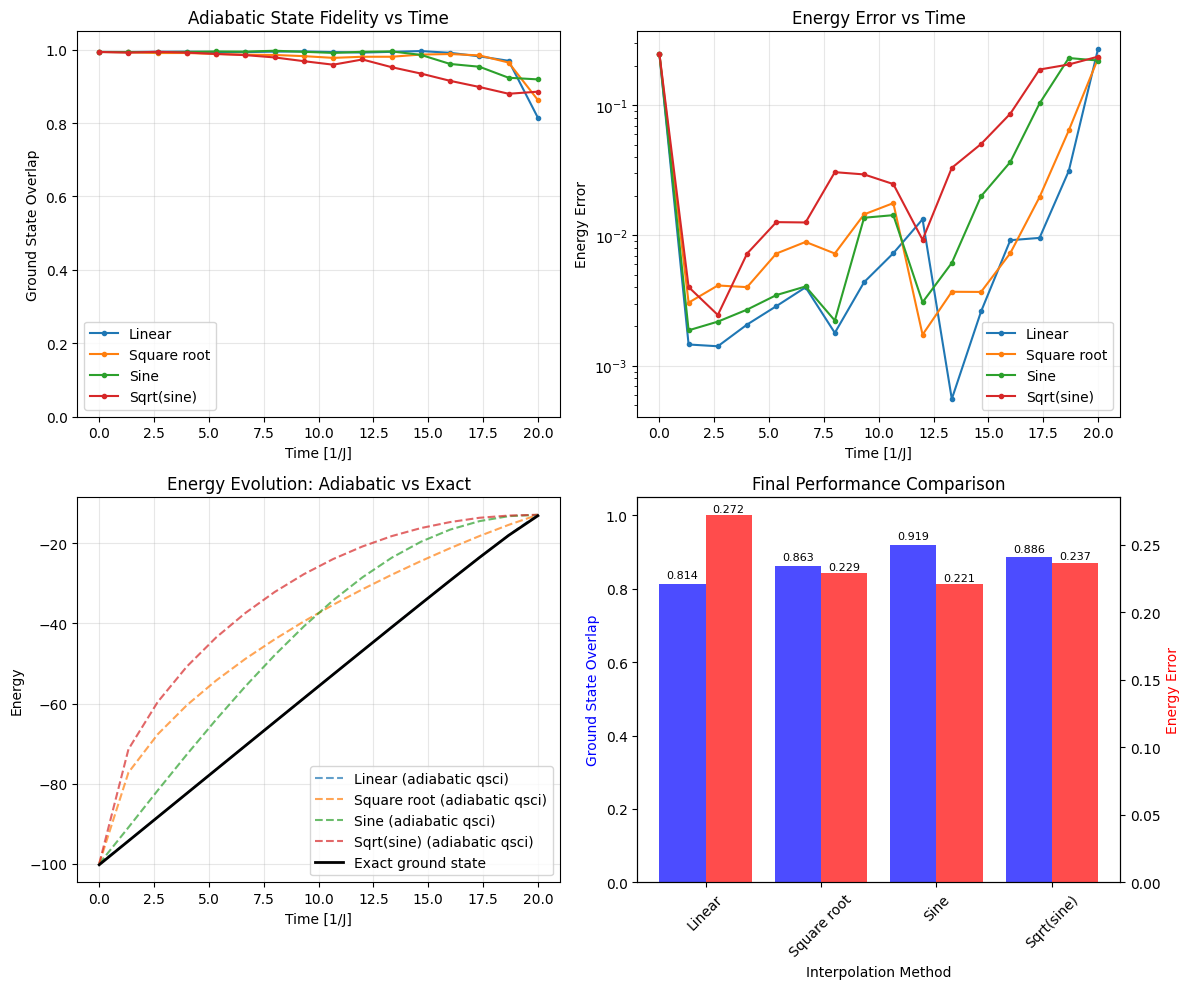


Summary Statistics:
Linear:
  Min overlap: 0.8145
  Avg overlap: 0.9804
  Max energy error: 0.4505
  Avg energy error: 0.1763

Square root:
  Min overlap: 0.8627
  Avg overlap: 0.9773
  Max energy error: 0.4003
  Avg energy error: 0.2289

Sine:
  Min overlap: 0.9190
  Avg overlap: 0.9800
  Max energy error: 0.3003
  Avg energy error: 0.1629

Sqrt(sine):
  Min overlap: 0.8798
  Avg overlap: 0.9557
  Max energy error: 0.4786
  Avg energy error: 0.2967



In [38]:
# Visualization of adiabatic fidelity results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Ground state overlaps over time
for name, data in results.items():
    ax1.plot(data['times'], data['overlaps'], label=name, marker='o', markersize=3)
ax1.set_xlabel('Time [1/J]')
ax1.set_ylabel('Ground State Overlap')
ax1.set_title('Adiabatic State Fidelity vs Time')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.05)

# Plot 2: Energy errors over time
for name, data in results.items():
    ax2.semilogy(data['times'], data['qsci_energy_errors'], label=name, marker='o', markersize=3)
ax2.set_xlabel('Time [1/J]')
ax2.set_ylabel('Energy Error')
ax2.set_title('Energy Error vs Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Energy evolution comparison
for name, data in results.items():
    ax3.plot(data['times'], data['qsci_energies'], '--', label=f'{name} (adiabatic qsci)', alpha=0.7)
# Plot exact energies (same for all, so just plot once)
ax3.plot(results['Linear']['times'], results['Linear']['exact_energies'], 'k-', 
         linewidth=2, label='Exact ground state')
ax3.set_xlabel('Time [1/J]')
ax3.set_ylabel('Energy')
ax3.set_title('Energy Evolution: Adiabatic vs Exact')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Final metrics comparison
names = list(results.keys())
final_overlaps = [results[name]['overlaps'][-1] for name in names]
final_errors = [results[name]['qsci_energy_errors'][-1] for name in names]

x_pos = np.arange(len(names))
ax4_twin = ax4.twinx()

bars1 = ax4.bar(x_pos - 0.2, final_overlaps, 0.4, label='Final Overlap', alpha=0.7, color='blue')
bars2 = ax4_twin.bar(x_pos + 0.2, final_errors, 0.4, label='Final Energy Error', alpha=0.7, color='red')

ax4.set_xlabel('Interpolation Method')
ax4.set_ylabel('Ground State Overlap', color='blue')
ax4_twin.set_ylabel('Energy Error', color='red')
ax4.set_title('Final Performance Comparison')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(names, rotation=45)
ax4.set_ylim(0, 1.05)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    ax4.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01, 
             f'{final_overlaps[i]:.3f}', ha='center', va='bottom', fontsize=8)
    ax4_twin.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.001, 
                  f'{final_errors[i]:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("="*60)
for name, data in results.items():
    min_overlap = min(data['overlaps'])
    avg_overlap = np.mean(data['overlaps'])
    max_error = max(data['energy_errors'])
    avg_error = np.mean(data['energy_errors'])
    
    print(f"{name}:")
    print(f"  Min overlap: {min_overlap:.4f}")
    print(f"  Avg overlap: {avg_overlap:.4f}")
    print(f"  Max energy error: {max_error:.4f}")
    print(f"  Avg energy error: {avg_error:.4f}")
    print()

In [39]:
# Test adiabatic fidelity with different interpolation schemes
import matplotlib.pyplot as plt

# Define interpolation functions
interp_linear = lambda x: x
interp_sqrt = lambda x: np.sqrt(x)
interp_sin = lambda x: np.sin(x * np.pi / 2)
interp_sqrtsin = lambda x: np.sqrt(np.sin(x * np.pi / 2))

interpolations = {
    'Linear': interp_linear,
    'Square root': interp_sqrt, 
    'Sine': interp_sin,
    'Sqrt(sine)': interp_sqrtsin
}

# Test parameters
QUBIT_COUNT = 10
H_START = 10.0
H_END = 1.05
N_STEPS = 15
N_SHOTS = 10**5
R = None
EVOLUTION_TIME = 20.0

print(f"Testing adiabatic fidelity for {QUBIT_COUNT} qubits")
print(f"h: {H_START} → {H_END}, Evolution time: {EVOLUTION_TIME}, Steps: {N_STEPS}")
print("="*60)

# Run tests for each interpolation
results = {}
for name, func in interpolations.items():
    print(f"Running {name} interpolation...")
    times, overlaps, energy_errors, exact_energies, adiabatic_energies, qsci_adiabatic_energies, qsci_energy_errors = test_adiabatic_fidelity(
        qubit_count=QUBIT_COUNT,
        h_start=H_START, 
        h_end=H_END,
        n_steps=N_STEPS,
        evolution_time=EVOLUTION_TIME,
        shot_count=N_SHOTS,
        interp_func=func,
        r=R
    )
    results[name] = {
        'times': times,
        'overlaps': overlaps,
        'energy_errors': energy_errors,
        'exact_energies': exact_energies,
        'adiabatic_energies': adiabatic_energies,
        'qsci_energy_errors': qsci_energy_errors,
        'qsci_energies': qsci_adiabatic_energies
    }
    
    final_overlap = overlaps[-1]
    final_energy_error = energy_errors[-1]
    final_qsci_energy_error = qsci_energy_errors[-1]
    print(f"  Final overlap with ground state: {final_overlap:.4f}")
    print(f"  Final energy error: {final_energy_error:.4f}")
    print(f"  Final qsci energy error: {final_qsci_energy_error:.4f}")
    print()

print("Test completed!")

Testing adiabatic fidelity for 10 qubits
h: 10.0 → 1.05, Evolution time: 20.0, Steps: 15
Running Linear interpolation...
  Final overlap with ground state: 0.8145
  Final energy error: 0.4505
  Final qsci energy error: 0.1283

Running Square root interpolation...
  Final overlap with ground state: 0.8627
  Final energy error: 0.4003
  Final qsci energy error: 0.0966

Running Sine interpolation...
  Final overlap with ground state: 0.9190
  Final energy error: 0.3003
  Final qsci energy error: 0.0090

Running Sqrt(sine) interpolation...
  Final overlap with ground state: 0.8855
  Final energy error: 0.4520
  Final qsci energy error: 0.0003

Test completed!


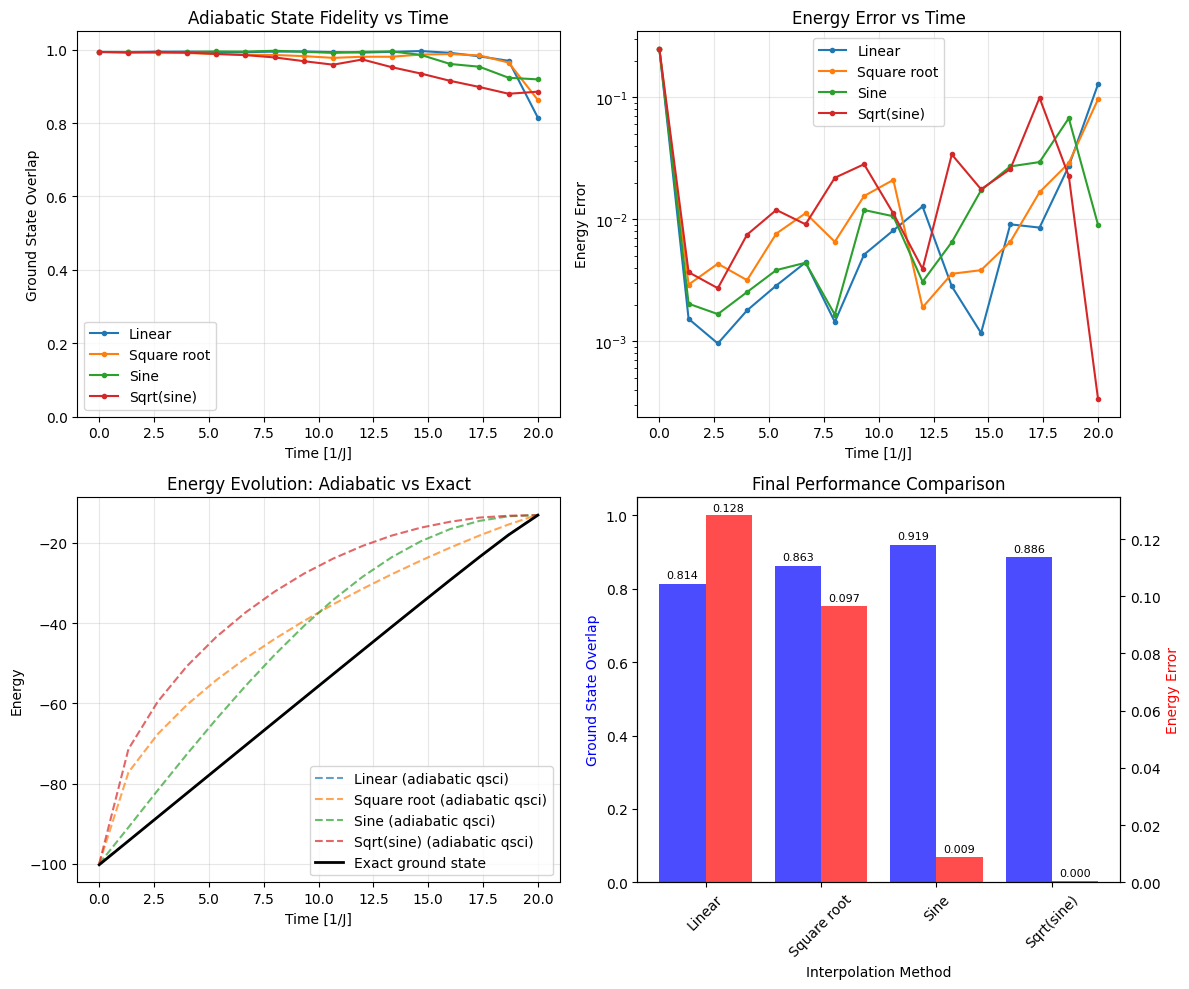


Summary Statistics:
Linear:
  Min overlap: 0.8145
  Avg overlap: 0.9804
  Max energy error: 0.4505
  Avg energy error: 0.1763

Square root:
  Min overlap: 0.8627
  Avg overlap: 0.9773
  Max energy error: 0.4003
  Avg energy error: 0.2289

Sine:
  Min overlap: 0.9190
  Avg overlap: 0.9800
  Max energy error: 0.3003
  Avg energy error: 0.1629

Sqrt(sine):
  Min overlap: 0.8798
  Avg overlap: 0.9557
  Max energy error: 0.4786
  Avg energy error: 0.2967



In [40]:
# Visualization of adiabatic fidelity results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Ground state overlaps over time
for name, data in results.items():
    ax1.plot(data['times'], data['overlaps'], label=name, marker='o', markersize=3)
ax1.set_xlabel('Time [1/J]')
ax1.set_ylabel('Ground State Overlap')
ax1.set_title('Adiabatic State Fidelity vs Time')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.05)

# Plot 2: Energy errors over time
for name, data in results.items():
    ax2.semilogy(data['times'], data['qsci_energy_errors'], label=name, marker='o', markersize=3)
ax2.set_xlabel('Time [1/J]')
ax2.set_ylabel('Energy Error')
ax2.set_title('Energy Error vs Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Energy evolution comparison
for name, data in results.items():
    ax3.plot(data['times'], data['qsci_energies'], '--', label=f'{name} (adiabatic qsci)', alpha=0.7)
# Plot exact energies (same for all, so just plot once)
ax3.plot(results['Linear']['times'], results['Linear']['exact_energies'], 'k-', 
         linewidth=2, label='Exact ground state')
ax3.set_xlabel('Time [1/J]')
ax3.set_ylabel('Energy')
ax3.set_title('Energy Evolution: Adiabatic vs Exact')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Final metrics comparison
names = list(results.keys())
final_overlaps = [results[name]['overlaps'][-1] for name in names]
final_errors = [results[name]['qsci_energy_errors'][-1] for name in names]

x_pos = np.arange(len(names))
ax4_twin = ax4.twinx()

bars1 = ax4.bar(x_pos - 0.2, final_overlaps, 0.4, label='Final Overlap', alpha=0.7, color='blue')
bars2 = ax4_twin.bar(x_pos + 0.2, final_errors, 0.4, label='Final Energy Error', alpha=0.7, color='red')

ax4.set_xlabel('Interpolation Method')
ax4.set_ylabel('Ground State Overlap', color='blue')
ax4_twin.set_ylabel('Energy Error', color='red')
ax4.set_title('Final Performance Comparison')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(names, rotation=45)
ax4.set_ylim(0, 1.05)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    ax4.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01, 
             f'{final_overlaps[i]:.3f}', ha='center', va='bottom', fontsize=8)
    ax4_twin.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.001, 
                  f'{final_errors[i]:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("="*60)
for name, data in results.items():
    min_overlap = min(data['overlaps'])
    avg_overlap = np.mean(data['overlaps'])
    max_error = max(data['energy_errors'])
    avg_error = np.mean(data['energy_errors'])
    
    print(f"{name}:")
    print(f"  Min overlap: {min_overlap:.4f}")
    print(f"  Avg overlap: {avg_overlap:.4f}")
    print(f"  Max energy error: {max_error:.4f}")
    print(f"  Avg energy error: {avg_error:.4f}")
    print()